In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('data.csv')
df.columns = ['date', 'volumn', 'amount', 'start_price', 'max_price', 'min_price', 'end_price', 'delta', 'count']
df.head()

,date,volumn,amount,start_price,max_price,min_price,end_price,delta,count
0,105/01/04,"3,564,019","16,956,319",4.80,4.84,4.68,4.69,-0.09,924
1,105/01/05,"2,504,182","11,692,096",4.69,4.74,4.62,4.63,-0.06,752
2,105/01/06,"4,528,184","20,886,563",4.63,4.69,4.57,4.60,-0.03,"1,073"
3,105/01/07,"6,462,223","29,128,814",4.60,4.63,4.45,4.49,-0.11,"1,275"
4,105/01/08,"3,729,252","16,547,177",4.32,4.49,4.32,4.49,0.00,829


In [8]:
def transform_year_format(year):
    year_list = year.split('/')
    year_list[0] = str(int(year_list[0]) + 1911)
    transform_year = '/'.join(year_list)
    
    return transform_year

df['date'] = pd.to_datetime(df['date'].apply(transform_year_format))
df['month'] = [x.month for x in df['date']]
df['day'] = [x.day for x in df['date']]
df['weekday'] = [x.weekday() for x in df['date']]

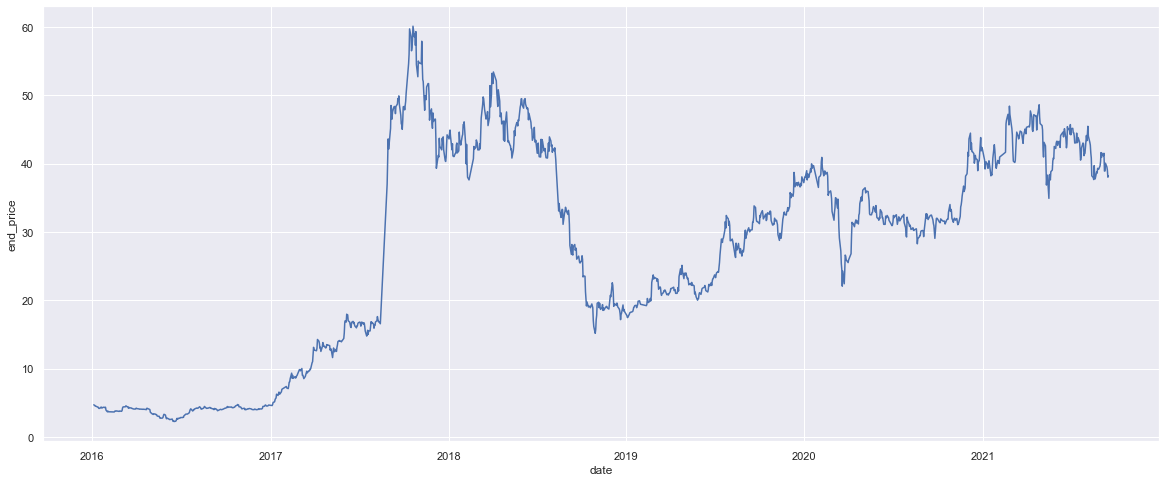

In [16]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.lineplot(data=df, x="date", y="end_price")

In [28]:
df_month = df.groupby(by='month', as_index=False).mean()
df_day = df.groupby(by='day', as_index=False).mean()
df_weekday = df.groupby(by='weekday', as_index=False).mean()

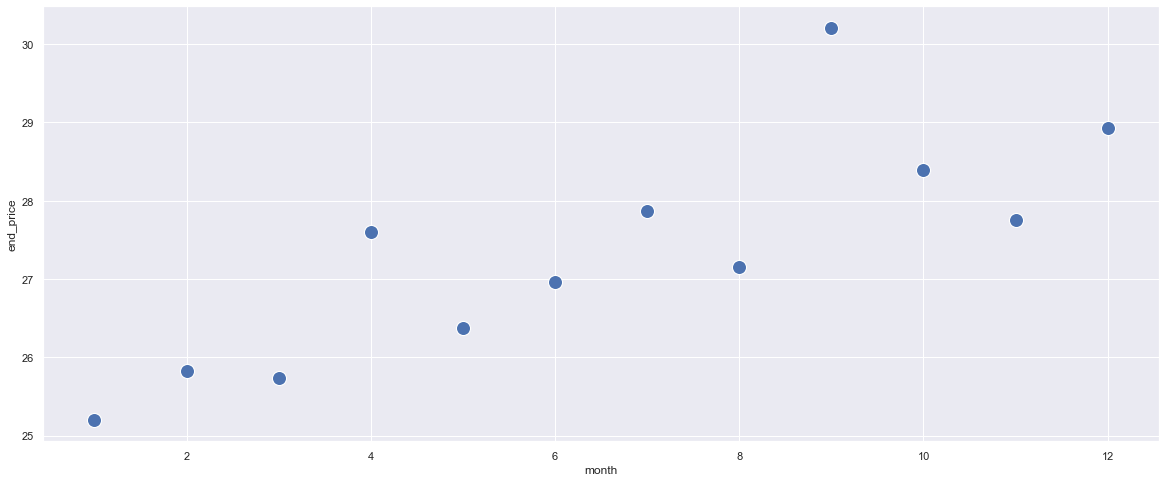

In [42]:
sns.scatterplot(
    data=df_month, x="month", y="end_price", s=200
)

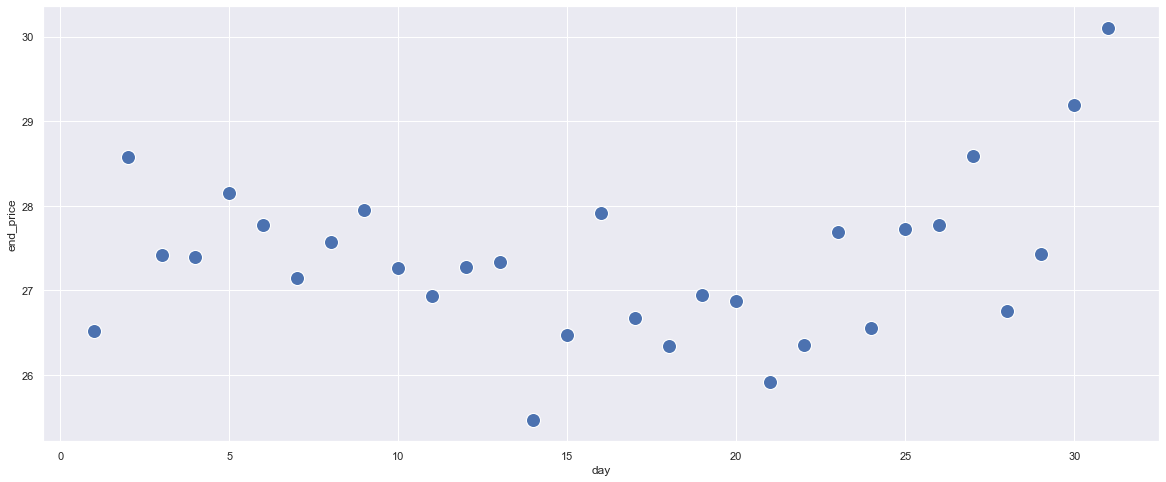

In [45]:
sns.scatterplot(
    data=df_day, x="day", y="end_price", s=200
)

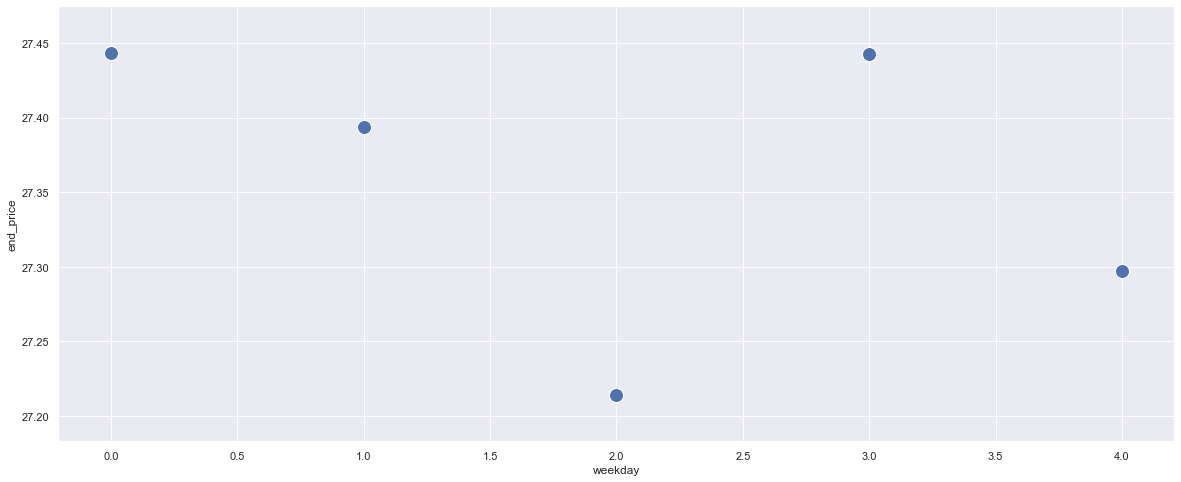

In [49]:
sns.scatterplot(
    data=df_weekday.query('weekday != 5'), x="weekday", y="end_price", s=200
)